### Pregunta de Negocio - Analistes de Finances i Risc Crediticio

> ¿Qué **umbrales de saldo** podrían indicar mayor **riesgo de morosidad**?
>

### Carga de datos

In [23]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")#ignorar advertencias


#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

#### Carga de datos

In [12]:
df = pd.read_csv("../Data/df_250526.csv")

### Analisis descriptivo de saldo segun default
comparar la distribucion de saldo entre los clientes que han tenido default y los que no.

```python

In [13]:
promedio = df.groupby('default')['balance'].mean().round(2)
mediana = df.groupby('default')['balance'].median().round(2)
minimo = df.groupby('default')['balance'].min().round(2)
maximo = df.groupby('default')['balance'].max()
Descriptiva = pd.DataFrame({
    'Promedio': promedio,
    'Mediana': mediana,
    'Mínimo': minimo,
    'Máximo': maximo
})


print(Descriptiva)


         Promedio  Mediana  Mínimo  Máximo
default                                   
False     1531.87    559.0   -3058   81204
True       -87.53      0.0   -6847    5249


### Agupacion de saldos en rangos

Tasa global de incumplimiento: 0.0150
Tasa de incumplimiento por decil de saldo:
    balance_decile  default  indice_riesgo
0                1   0.0667           4.44
1                2   0.0288           1.92
2                3   0.0325           2.17
3                4   0.0166           1.11
4                5   0.0068           0.45
5                6   0.0122           0.81
6                7   0.0069           0.46
7                8   0.0006           0.04
8                9   0.0034           0.23
9               10   0.0040           0.27
10              11   0.0069           0.46
11              12   0.0000           0.00
12              13   0.0011           0.07
13              14   0.0000           0.00
14              15   0.0017           0.11


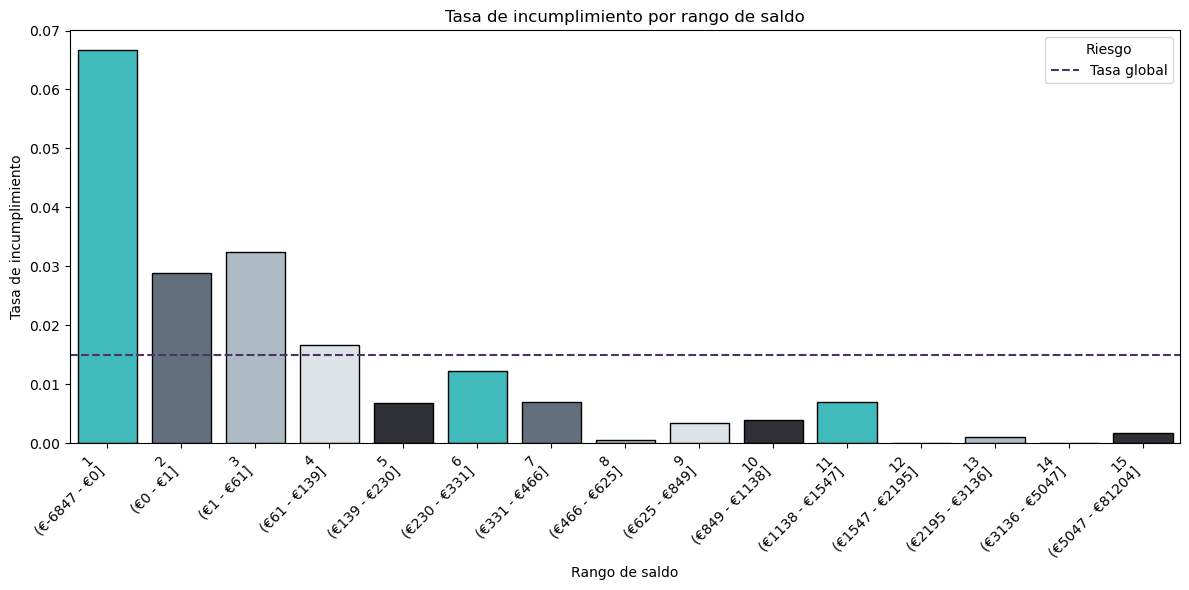

In [4]:
#  Crear rangos de balance para agrupar clientes en grupos iguales
df['balance_decile'] = pd.qcut(df['balance'], q=15, labels=False)

# Calcular la tasa de incumplimiento (default) por cada decil
default_rates = (df.groupby('balance_decile')['default'].mean().reset_index()) #la media aritmética en ese grupo equivale a la proporción (o tasa) de incumplimiento
default_rates['default'] = default_rates['default'].round(4) 
default_rates['balance_decile'] = default_rates['balance_decile'] + 1
Tasa_global_impagos = df['default'].mean()
print(f"Tasa global de incumplimiento: {Tasa_global_impagos:.4f}")
# Calculamos el indice de riesgo por decil riesgo/riesgo global
default_rates['indice_riesgo'] = default_rates['default'] / Tasa_global_impagos
default_rates['indice_riesgo'] = default_rates['indice_riesgo'].round(2)

#  Mostrar resultados en consola
print("Tasa de incumplimiento por decil de saldo:")
print(default_rates)
df['balance_decile_range'] = pd.qcut(df['balance'], q=15)

# Obtener los intervalos únicos en orden
balance_ranges = df['balance_decile_range'].cat.categories
decile_labels = [
    f"{i+1}\n(€{int(interval.left)} - €{int(interval.right)}]"
    for i, interval in enumerate(balance_ranges)
]

#default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates, x='balance_decile', y='default', palette=custom_palette, edgecolor='black')
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(15), labels=decile_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por rango de saldo')
plt.xlabel('Rango de saldo')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Riesgo')
plt.tight_layout()
plt.show()





### Preparacion entrenamiento

In [ ]:
# data frame boleano
df_bool = df[['default', 'housing', 'loan', 'deposit', 'balance']].copy()
df_bool['housing'].fillna(df_bool['housing'].mode()[0], inplace=True)

 

for col in ['default','housing', 'loan', 'deposit']:
    df_bool[col] = df_bool[col].astype(int)

# Definir las variables predictoras y la variable objetivo
X = df_bool[[ 'housing', 'loan', 'deposit']]
y = df_bool['default']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



### Regresion logistica

In [ ]:
log_model = LogisticRegression(class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]
# Resultados
print("=== Regresión Logística ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_prob):.4f}")

coefs = pd.Series(log_model.coef_[0], index=X.columns)
print("Coeficientes del modelo:")
print(coefs.sort_values(ascending=False))



=== Regresión Logística (Variables Booleanas) ===
[[6739  989]
 [  81   48]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7728
           1       0.05      0.37      0.08       129

    accuracy                           0.86      7857
   macro avg       0.52      0.62      0.50      7857
weighted avg       0.97      0.86      0.91      7857

AUC: 0.6609
Coeficientes del modelo:
loan       1.230219
housing   -0.019698
deposit   -0.616845
dtype: float64
Coeficientes del modelo:
loan       1.230219
housing   -0.019698
deposit   -0.616845
dtype: float64


### Arbol de decision

=== Árbol de Decisión ===
[[7728    0]
 [ 129    0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7728
           1       0.00      0.00      0.00       129

    accuracy                           0.98      7857
   macro avg       0.49      0.50      0.50      7857
weighted avg       0.97      0.98      0.98      7857

AUC: 0.6790


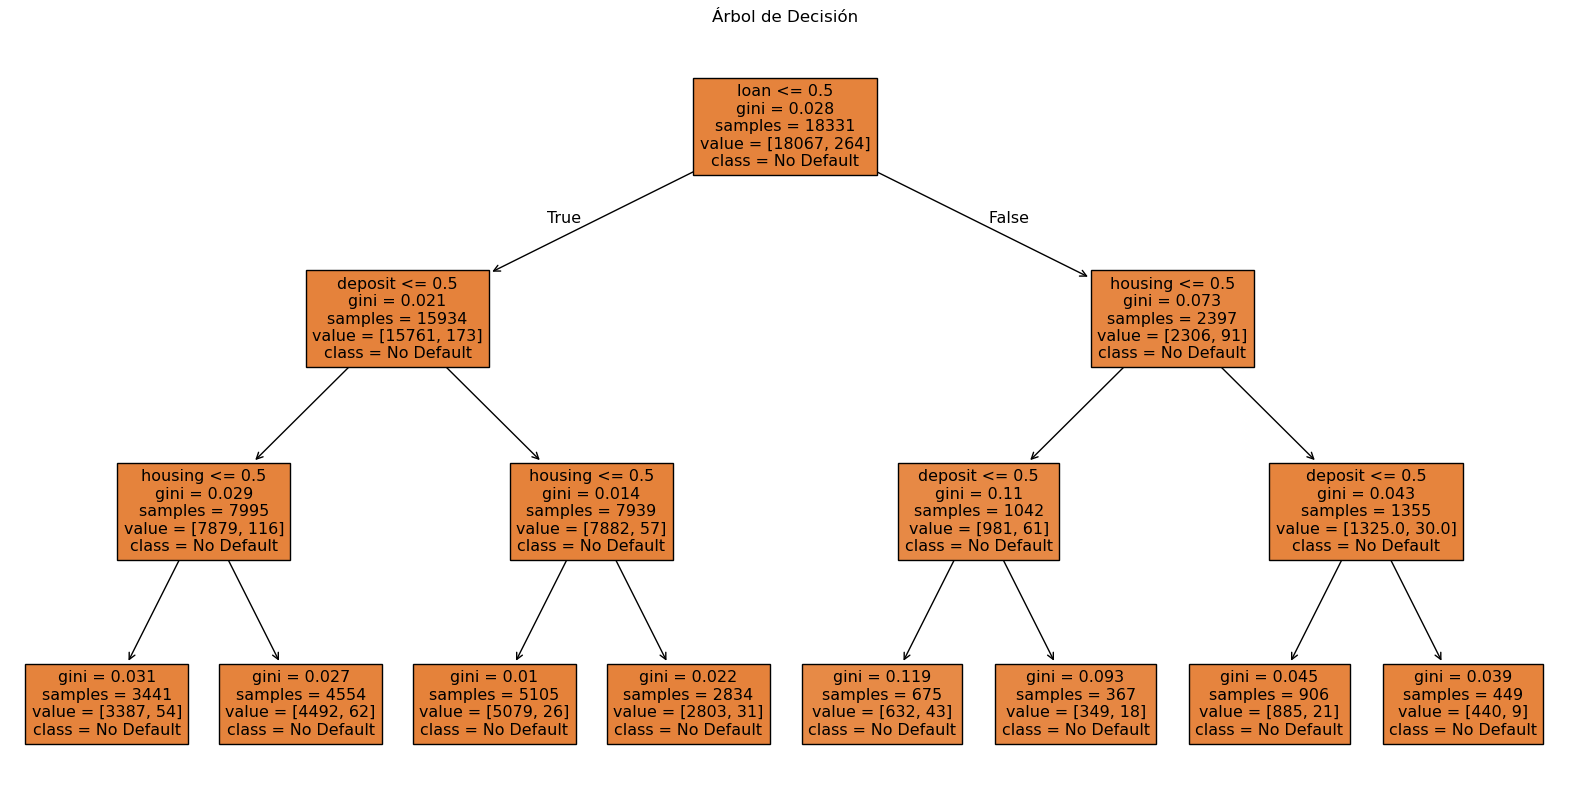

In [26]:
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:,1]

print("=== Árbol de Decisión ===")
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
print(f"AUC: {roc_auc_score(y_test, y_prob_tree):.4f}")

# Visualización del árbol
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, class_names=["No Default", "Default"], filled=True)
plt.title("Árbol de Decisión")
plt.show()